# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [3]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.
The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.2299999948590994


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

#### Import necessary packages

In [10]:
# Import necessary packages

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import ddpg_agent
import workspace_utils

#### Training of the agent (DDPG)

In [8]:
# Training of the agent (DDPG)

def ddpg(n_episodes=1000, max_t=10000, print_every=100): #max_t=500
    """Deep Deterministic Policy Gradients DDPG
    Params
    ======
        n_episodes (int) = maximum number of episodes
        max_t (int) = max number of timesteps per episode
        print_every (int) = orint results every n episodes
    """

    scores = [] # list containing scores from each episode
    scores_mean = [] # list mean score
    scores_window = deque(maxlen=100)  # last 100 scores
    
    env_info = env.reset(train_mode=True)[brain_name] # reset env
    
    for i_episode in range(1, n_episodes+1):
        # Reset agent, noise, env
        agent.noise.reset()
        agent.reset()
        state = env_info.vector_observations[0] # get current state of 1 agent
                
        #score = np.zeros(num_agents) # set score/ reward to zero if using multiple agents
        score = 0
        
        for t in range(max_t):
            action = agent.act(state) # select an action to be send to the agent
            env_info = env.step(action)[brain_name] # send action to env
            next_state = env_info.vector_observations[0] # get next state from env
            reward = env_info.rewards[0] # get reward from env
            done = env_info.local_done[0] # check if episode is done
            
            agent.step(state, action, reward, next_state, done) # perform step
            
            # Update statistical variables
            state = next_state
            score += reward
            
            if done:
                break 
        
        # Store score and calculate mean
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        scores_mean.append(np.mean(scores_window))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_env_solved_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_env_solved_critic.pth')
            break
            
    return scores, scores_mean


In [9]:
with workspace_utils.active_session():
    agent = ddpg_agent.Agent(state_size=state_size, action_size=action_size, random_seed=0)
    scores, mean = ddpg(n_episodes=2000, max_t=10000, print_every=100)

Actor net - local:  Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Actor net - target:  Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic net - local:  Critic(
  (fcs1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  

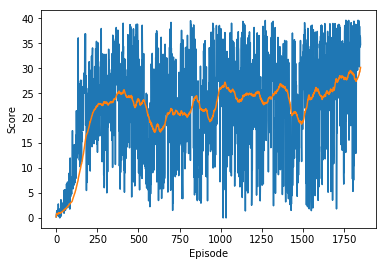

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(mean)), mean, label='Mean')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

#### Watch a Smart Agent

In [14]:
import ddpg_agent
import torch.optim as optim
import ddpg_agent

agent = ddpg_agent.Agent(state_size, action_size, random_seed = 100)

agent.actor_local.load_state_dict(torch.load('checkpoint_env_solved_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_env_solved_critic.pth'))

n_episodes=1000
score = 0

env_info = env.reset(train_mode=False)[brain_name] # reset env
state = env_info.vector_observations[0] # get current state

for i_eps in range(1,n_episodes+1):
    
    action = agent.act(state) # choose action
    env_info = env.step(action)[brain_name] # send action to env
    next_state = env_info.vector_observations[0] # get next state of env
    reward = env_info.rewards[0] # get reward from env
    done = env_info.local_done[0] # check if episode is done

    score += reward
    state = next_state
    if done:
        break 

print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_eps, np.mean(score)), end="")

Actor net - local:  Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Actor net - target:  Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic net - local:  Critic(
  (fcs1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  